In [1]:
!unzip /content/speech_dataset.zip -d /content/

Archive:  /content/speech_dataset.zip
   creating: /content/speech_dataset/
   creating: /content/speech_dataset/A_sound/
  inflating: /content/speech_dataset/A_sound/CT001_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT004_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT010_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT013_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT014_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT015_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT018_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT019_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT020_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT021_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT022_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT023_phonationA.wav  
  inflating: /content/speech_dataset/A_sound/CT026_phonationA.

In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Base directory with label folders
base_dir = '/content/speech_dataset'
image_dir = '/content/spectrograms'
os.makedirs(image_dir, exist_ok=True)

for root, dirs, files in os.walk(base_dir):
    print(f"Current directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")

print("Walking through base directory...")

for root, dirs, files in os.walk(base_dir):
    # Skip base_dir itself
    if root == base_dir:
        continue

    label = os.path.basename(root)
    print(f"\nFound label folder: {label}")
    label_output_dir = os.path.join(image_dir, label)
    os.makedirs(label_output_dir, exist_ok=True)

    for file in files:
        if not file.lower().endswith('.wav'):
            continue  # Skip non-wav files

        filepath = os.path.join(root, file)
        print(f"Loading: {filepath}")

        try:
            y, sr = librosa.load(filepath, sr=None)
            if len(y) == 0:
                print(f"Empty audio: {file}")
                continue

            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)

            plt.figure(figsize=(4, 3))
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.axis('off')

            out_path = os.path.join(label_output_dir, file.replace('.wav', '.png'))
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            print(f"Saved spectrogram: {out_path}")

        except Exception as e:
            print(f"Error processing {file}: {e}")

Current directory: /content/speech_dataset
Subdirectories: ['PA_sound', 'KA_sound', 'TA_sound', 'U_sound', 'E_sound', 'Dataset', 'O_sound', 'I_sound', 'A_sound']
Files: []
Current directory: /content/speech_dataset/PA_sound
Subdirectories: []
Files: ['CT038_rhythmPA.wav', 'PZ101_rhythmPA.wav', 'PZ029_rhythmPA.wav', 'CT061_rhythmPA.wav', 'CT040_rhythmPA.wav', 'PZ001_rhythmPA.wav', 'PZ045_rhythmPA.wav', 'PZ062_rhythmPA.wav', 'PZ092_rhythmPA.wav', 'PZ066_rhythmPA.wav', 'PZ011_rhythmPA.wav', 'CT004_rhythmPA.wav', 'PZ063_rhythmPA.wav', 'PZ025_rhythmPA.wav', 'PZ009_rhythmPA.wav', 'PZ039_rhythmPA.wav', 'PZ051_rhythmPA.wav', 'PZ033_rhythmPA.wav', 'PZ098_rhythmPA.wav', 'CT060_rhythmPA.wav', 'PZ056_rhythmPA.wav', 'PZ064_rhythmPA.wav', 'PZ050_rhythmPA.wav', 'PZ091_rhythmPA.wav', 'CT057_rhythmPA.wav', 'PZ035_rhythmPA.wav', 'PZ104_rhythmPA.wav', 'PZ089_rhythmPA.wav', 'PZ004_rhythmPA.wav', 'PZ022_rhythmPA.wav', 'PZ108_rhythmPA.wav', 'CT027_rhythmPA.wav', 'PZ094_rhythmPA.wav', 'CT051_rhythmPA.wav', '

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [4]:
# Base directory
image_dir = '/content/spectrograms'
img_height, img_width = 128, 128  # Resize images to this shape
num_healthy = 51  # First 50 files are healthy

In [5]:
# Prepare datasets for training and testing
X_train = []
y_train = []
X_test = []
y_test = []

In [6]:
# Loop through label directories
for label_folder in sorted(os.listdir(image_dir)):
    folder_path = os.path.join(image_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = load_img(img_path, target_size=(img_height, img_width), color_mode='rgb')
        img_array = img_to_array(img) / 255.0  # Normalize

        # Save the last spectrogram for testing (assuming the last file in each folder is the test file)
        if  i <=5 or i >= len(files) - 5:
            X_test.append(img_array)
            y_test.append(0 if i < num_healthy else 1)  # 0 = healthy, 1 = ALS
        else:
            X_train.append(img_array)
            y_train.append(0 if i < num_healthy else 1)  # 0 = healthy, 1 = ALS
            from sklearn.utils import shuffle

In [7]:
# Shuffle the training set after loading it
X_train, y_train = shuffle(X_train, y_train, random_state=42)
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=30, batch_size=32)

# Save and evaluate
model.save('/content/als_vs_healthy_cnn_improved.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Improved Test Accuracy: {test_acc * 100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.6189 - loss: 0.7726
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6278 - loss: 0.6777
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6467 - loss: 0.6530
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6584 - loss: 0.6596
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6704 - loss: 0.6383
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6550 - loss: 0.6428
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6887 - loss: 0.6410
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6768 - loss: 0.6333
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6927 - loss: 0.6254
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6662 - loss: 0.6385
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6942 - loss: 0.6194
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accurac

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.5000 - loss: 0.9529
Improved Test Accuracy: 50.00%


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Paths
image_dir = "/content/spectrograms"
img_height, img_width = 128, 128  # Standard resize size

# Get folders
all_folders = sorted([f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))])
train_folders = all_folders[:-1]
test_folder = all_folders[-1]

# Load data function
def load_data(folders):
    X, y = [], []
    for folder in folders:
        label_path = os.path.join(image_dir, folder)
        files = sorted(os.listdir(label_path))
        for idx, file in enumerate(files):
            if file.endswith('.png'):
                img_path = os.path.join(label_path, file)
                img = Image.open(img_path).convert('RGB').resize((img_width, img_height))
                img = np.array(img) / 255.0
                X.append(img)
                # Label based on index: first 50 = healthy (0), rest = ALS (1)
                y.append(0 if idx < 50 else 1)
    return np.array(X), np.array(y)

# Load training data
X_train, y_train = load_data(train_folders)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Define improved CNN model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(datagen.flow(X_train, y_train, batch_size=16),
          epochs=38)

# Save model
model.save('/content/cnn_health_vs_als_improved.h5')
print("✅ Model saved.")

# Evaluate on the test folder
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🧪 Test accuracy using folder '{test_folder}': {test_acc * 100:.2f}%")


Epoch 1/38


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.5526 - loss: 2.4157
Epoch 2/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6035 - loss: 0.9637
Epoch 3/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6717 - loss: 0.7064
Epoch 4/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.6272 - loss: 0.7024
Epoch 5/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6529 - loss: 0.6496
Epoch 6/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6686 - loss: 0.6374
Epoch 7/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6776 - loss: 0.6227
Epoch 8/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7014 - loss: 0.5982
Epoch 9/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6454 - loss: 0.6145
Epoch 10/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6571 - loss: 0.6139
Epoch 11/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6553 - loss: 0.6782
Epoch 12/38
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6477 -

✅ Model saved.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.4748 - loss: 1.0542

🧪 Test accuracy using folder 'U_sound': 48.86%


In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from sklearn.utils import shuffle

# Updated image size for ResNet
img_height, img_width = 224, 224

# Preprocessing + dataset loading
# (Update load_img target size and use preprocess_input)
X_train, y_train, X_test, y_test = [], [], [], []

for label_folder in sorted(os.listdir(image_dir)):
    folder_path = os.path.join(image_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = load_img(img_path, target_size=(img_height, img_width), color_mode='rgb')
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)  # Use ResNet-specific preprocessing

        if i <= 5 or i >= len(files) - 5:
            X_test.append(img_array)
            y_test.append(0 if i < num_healthy else 1)
        else:
            X_train.append(img_array)
            y_train.append(0 if i < num_healthy else 1)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4382 - loss: 0.7707

🧪 Test accuracy using folder 'U_sound': 45.45%


<ipython-input-25-6820aaa4ebda>:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1145']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.66760, saving model to best_mobilenetv2_model.h5


31/31 - 21s - 672ms/step - accuracy: 0.5189 - loss: 0.9261 - val_accuracy: 0.5592 - val_loss: 0.6676
Epoch 2/30

Epoch 2: val_loss improved from 0.66760 to 0.60771, saving model to best_mobilenetv2_model.h5


31/31 - 7s - 225ms/step - accuracy: 0.5393 - loss: 0.7801 - val_accuracy: 0.6735 - val_loss: 0.6077
Epoch 3/30

Epoch 3: val_loss did not improve from 0.60771
31/31 - 1s - 41ms/step - accuracy: 0.5802 - loss: 0.7362 - val_accuracy: 0.6531 - val_loss: 0.6445
Epoch 4/30

Epoch 4: val_loss did not improve from 0.60771
31/31 - 3s - 83ms/step - accuracy: 0.6415 - loss: 0.6614 - val_accuracy: 0.6694 - val_loss: 0.6423
Epoch 5/30

Epoch 5: val_loss did not improve from 0.60771
31/31 - 1s - 41ms/step - accuracy: 0.6078 - loss: 0.6658 - val_accuracy: 0.6653 - val_loss: 0.6191
Epoch 6/30

Epoch 6: val_loss improved from 0.60771 to 0.59809, saving model to best_mobilenetv2_model.h5


31/31 - 2s - 53ms/step - accuracy: 0.5975 - loss: 0.6486 - val_accuracy: 0.6408 - val_loss: 0.5981
Epoch 7/30

Epoch 7: val_loss did not improve from 0.59809
31/31 - 1s - 42ms/step - accuracy: 0.6353 - loss: 0.6356 - val_accuracy: 0.6531 - val_loss: 0.6276
Epoch 8/30

Epoch 8: val_loss did not improve from 0.59809
31/31 - 1s - 43ms/step - accuracy: 0.6517 - loss: 0.6091 - val_accuracy: 0.6367 - val_loss: 0.6082
Epoch 9/30

Epoch 9: val_loss did not improve from 0.59809
31/31 - 2s - 80ms/step - accuracy: 0.6496 - loss: 0.6089 - val_accuracy: 0.6490 - val_loss: 0.6002
Epoch 10/30

Epoch 10: val_loss improved from 0.59809 to 0.57740, saving model to best_mobilenetv2_model.h5


31/31 - 3s - 94ms/step - accuracy: 0.6599 - loss: 0.5925 - val_accuracy: 0.6694 - val_loss: 0.5774
Epoch 11/30

Epoch 11: val_loss did not improve from 0.57740
31/31 - 2s - 68ms/step - accuracy: 0.7150 - loss: 0.5773 - val_accuracy: 0.6694 - val_loss: 0.5807
Epoch 12/30

Epoch 12: val_loss did not improve from 0.57740
31/31 - 1s - 41ms/step - accuracy: 0.7007 - loss: 0.5597 - val_accuracy: 0.6449 - val_loss: 0.6016
Epoch 13/30

Epoch 13: val_loss did not improve from 0.57740
31/31 - 3s - 83ms/step - accuracy: 0.6752 - loss: 0.5687 - val_accuracy: 0.6612 - val_loss: 0.5887
Epoch 14/30

Epoch 14: val_loss improved from 0.57740 to 0.57392, saving model to best_mobilenetv2_model.h5


31/31 - 3s - 93ms/step - accuracy: 0.7109 - loss: 0.5480 - val_accuracy: 0.6816 - val_loss: 0.5739
Epoch 15/30

Epoch 15: val_loss did not improve from 0.57392
31/31 - 2s - 70ms/step - accuracy: 0.7242 - loss: 0.5478 - val_accuracy: 0.6694 - val_loss: 0.5790
Epoch 16/30

Epoch 16: val_loss improved from 0.57392 to 0.56835, saving model to best_mobilenetv2_model.h5


31/31 - 3s - 94ms/step - accuracy: 0.7109 - loss: 0.5419 - val_accuracy: 0.6898 - val_loss: 0.5684
Epoch 17/30

Epoch 17: val_loss did not improve from 0.56835
31/31 - 1s - 42ms/step - accuracy: 0.7079 - loss: 0.5472 - val_accuracy: 0.6735 - val_loss: 0.5715
Epoch 18/30

Epoch 18: val_loss did not improve from 0.56835
31/31 - 1s - 46ms/step - accuracy: 0.7446 - loss: 0.5260 - val_accuracy: 0.6857 - val_loss: 0.5770
Epoch 19/30

Epoch 19: val_loss improved from 0.56835 to 0.56535, saving model to best_mobilenetv2_model.h5


31/31 - 3s - 92ms/step - accuracy: 0.7211 - loss: 0.5282 - val_accuracy: 0.6939 - val_loss: 0.5654
Epoch 20/30

Epoch 20: val_loss improved from 0.56535 to 0.56083, saving model to best_mobilenetv2_model.h5


31/31 - 4s - 128ms/step - accuracy: 0.7222 - loss: 0.5182 - val_accuracy: 0.7020 - val_loss: 0.5608
Epoch 21/30

Epoch 21: val_loss did not improve from 0.56083
31/31 - 2s - 66ms/step - accuracy: 0.7406 - loss: 0.5165 - val_accuracy: 0.6939 - val_loss: 0.5707
Epoch 22/30

Epoch 22: val_loss improved from 0.56083 to 0.54725, saving model to best_mobilenetv2_model.h5


31/31 - 2s - 54ms/step - accuracy: 0.7406 - loss: 0.5140 - val_accuracy: 0.7020 - val_loss: 0.5472
Epoch 23/30

Epoch 23: val_loss did not improve from 0.54725
31/31 - 1s - 41ms/step - accuracy: 0.7559 - loss: 0.4978 - val_accuracy: 0.7020 - val_loss: 0.5711
Epoch 24/30

Epoch 24: val_loss did not improve from 0.54725
31/31 - 3s - 83ms/step - accuracy: 0.7743 - loss: 0.4864 - val_accuracy: 0.6776 - val_loss: 0.5877
Epoch 25/30

Epoch 25: val_loss did not improve from 0.54725
31/31 - 1s - 43ms/step - accuracy: 0.7497 - loss: 0.4942 - val_accuracy: 0.7143 - val_loss: 0.5536
Epoch 26/30

Epoch 26: val_loss improved from 0.54725 to 0.53964, saving model to best_mobilenetv2_model.h5


31/31 - 2s - 53ms/step - accuracy: 0.7559 - loss: 0.4956 - val_accuracy: 0.7184 - val_loss: 0.5396
Epoch 27/30

Epoch 27: val_loss did not improve from 0.53964
31/31 - 2s - 69ms/step - accuracy: 0.7753 - loss: 0.4763 - val_accuracy: 0.6612 - val_loss: 0.5711
Epoch 28/30

Epoch 28: val_loss did not improve from 0.53964
31/31 - 1s - 41ms/step - accuracy: 0.7804 - loss: 0.4688 - val_accuracy: 0.6939 - val_loss: 0.5552
Epoch 29/30

Epoch 29: val_loss did not improve from 0.53964
31/31 - 1s - 42ms/step - accuracy: 0.7886 - loss: 0.4593 - val_accuracy: 0.6980 - val_loss: 0.5472
Epoch 30/30

Epoch 30: val_loss did not improve from 0.53964
31/31 - 1s - 41ms/step - accuracy: 0.7937 - loss: 0.4560 - val_accuracy: 0.6816 - val_loss: 0.5508


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7267 - loss: 0.5297

🧪 Test Accuracy: 71.84%


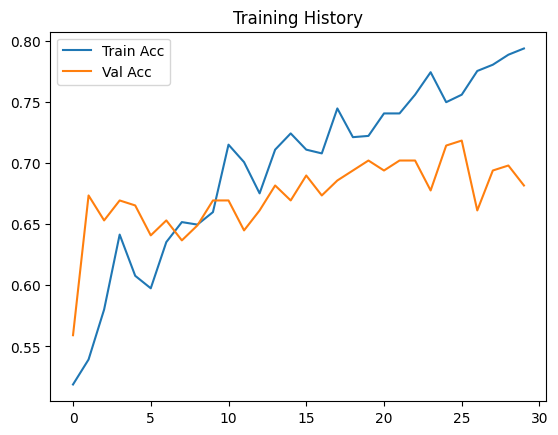

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Constants
IMG_SIZE = 224
DATA_DIR = '/content/spectrograms'  # <-- Set your actual directory path here
NUM_HEALTHY = 50

# Load dataset
def load_data(data_dir, img_size=224):
    X = []
    y = []
    for folder in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, folder)
        if not os.path.isdir(path): continue

        files = sorted([f for f in os.listdir(path) if f.endswith('.png')])
        for i, file in enumerate(files):
            img_path = os.path.join(path, file)
            img = load_img(img_path, target_size=(img_size, img_size))
            img_array = img_to_array(img)
            X.append(img_array)
            label = 0 if i < NUM_HEALTHY else 1
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess
X, y = load_data(DATA_DIR, IMG_SIZE)
X = preprocess_input(X)  # MobileNetV2 specific preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mobilenetv2_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
base_model.trainable = False  # Freeze for transfer learning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint],
    verbose=2
)

# Reload best model (optional but recommended)
from tensorflow.keras.models import load_model
model = load_model('best_mobilenetv2_model.h5')

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🧪 Test Accuracy: {test_acc * 100:.2f}%")

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Training History')
plt.show()
